In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras.applications import mobilenet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Training_data_aug

In [2]:
# https://drive.google.com/file/d/1UZwbPJc71eb6sThp6m2ZxSv7bpvPyVXE/view?usp=sharing
import gdown, os, zipfile

file_id = '1UZwbPJc71eb6sThp6m2ZxSv7bpvPyVXE'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss-train'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1UZwbPJc71eb6sThp6m2ZxSv7bpvPyVXE
From (redirected): https://drive.google.com/uc?id=1UZwbPJc71eb6sThp6m2ZxSv7bpvPyVXE&confirm=t&uuid=e9086ae4-ccd3-4ca6-83f3-8c787dd103de
To: /content/file.zip
100%|██████████| 130M/130M [00:01<00:00, 124MB/s]


### Training 메타데이터

In [3]:
from sklearn.model_selection import train_test_split
import os
def load_data(base_dir = 'hair-loss-train'):
  tr_images = []
  tr_labels = []
  tr_class_names = []

  for tr_class_name in os.listdir(base_dir):
    tr_class_name_path = os.path.join(base_dir, tr_class_name)

    if os.path.isdir(tr_class_name_path):
      for tr_image_name in os.listdir(tr_class_name_path):
        tr_image_path = os.path.join(tr_class_name_path, tr_image_name)
        tr_images.append(tr_image_path)
        tr_labels.append(int(tr_class_name))

  return np.array(tr_images), np.array(tr_labels)

tr_images, tr_labels  = load_data()

tr_images.shape, tr_labels.shape


((5605,), (5605,))

### Training 데이터 resize

In [4]:
# training_data_set resize

import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for tr_image_path in tr_images:
    tr_image = cv2.imread(tr_image_path)
    tr_image = cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB)
    tr_image = cv2.resize(tr_image, IMAGE_SIZE)
    processed_images.append(tr_image)

# 최종 이미지
tr_images = np.array(processed_images)
print(tr_images.shape)
print(tr_labels.shape)

(5605, 224, 224, 3)
(5605,)


## Validation 데이터

In [5]:
# https://drive.google.com/file/d/1OA_azGaB_FUCFJNWQS3-D0xMtJyh791E/view?usp=sharing

file_id = '1OA_azGaB_FUCFJNWQS3-D0xMtJyh791E'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss-val'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1OA_azGaB_FUCFJNWQS3-D0xMtJyh791E
From (redirected): https://drive.google.com/uc?id=1OA_azGaB_FUCFJNWQS3-D0xMtJyh791E&confirm=t&uuid=aa7c546a-a1ad-4cc0-b416-6da480c65229
To: /content/file.zip
100%|██████████| 1.27G/1.27G [00:16<00:00, 77.2MB/s]


## Validation 메타데이터

In [6]:
from sklearn.model_selection import train_test_split
import os
def load_data(base_dir = 'hair-loss-val/Validation'):
  images = []
  labels = []
  class_names = []

  for class_name in os.listdir(base_dir):
    class_name_path = os.path.join(base_dir, class_name)

    if os.path.isdir(class_name_path):
      for image_name in os.listdir(class_name_path):
        image_path = os.path.join(class_name_path, image_name)
        images.append(image_path)
        labels.append(int(class_name))

  return np.array(images), np.array(labels)

images, labels  = load_data()

images.shape, labels.shape

((5288,), (5288,))

In [7]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5288, 224, 224, 3)
(5288,)


## 데이터 셋 분할 (val / test)

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 훈련/테스트
train_images, te_images, train_labels, te_labels = train_test_split(
    images, labels, test_size=0.5, random_state=0, stratify=labels
)

test_images, val_images, test_labels, val_labels = train_test_split(te_images, te_labels, test_size=0.5, random_state=0, )

tr_labels = to_categorical(tr_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

print(tr_images.shape, val_images.shape, test_images.shape)
print(tr_labels.shape, val_labels.shape, test_labels.shape)

(5605, 224, 224, 3) (1322, 224, 224, 3) (1322, 224, 224, 3)
(5605, 4) (1322, 4) (1322, 4)


## Sequence 객체

In [9]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

BATCH_SIZE = 64
IMAGE_SIZE = 224

class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], self.image_size, self.image_size, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 리사이즈
      # image = cv2.resize(image, (self.image_size, self.image_size))

      # 스케일링
      if self.preprocess_function is not None:
        image = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


In [10]:
# 학습/검증/평가용 Sequence 객체 준비
from tensorflow.keras.applications.mobilenet import preprocess_input


tr_seq = HairLossSequence(tr_images, tr_labels, preprocess_function=preprocess_input, shuffle=True)
val_seq = HairLossSequence(val_images, val_labels, preprocess_function=preprocess_input, shuffle=False)
test_seq = HairLossSequence(test_images, test_labels, preprocess_function=preprocess_input, shuffle=False)

tr_labels = to_categorical(tr_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

tr_batch_images, tr_batch_labels = next(iter(tr_seq))
tr_batch_images.shape, tr_batch_labels.shape


((64, 224, 224, 3), (64, 4))

## MobileNet 모델

In [11]:
model = applications.MobileNetV2()
model.summary()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
from tensorflow.keras.regularizers import l2


base_model = applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

model = models.Model(base_model.input, output)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,342,180 (8.93 MB)

 Trainable params: 2,308,068 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 295ms/step - accuracy: 0.5287 - loss: 1.2428 - val_accuracy: 0.1528 - val_loss: 1.9154 - learning_rate: 0.0010
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.6823 - loss: 0.8812 - val_accuracy: 0.1293 - val_loss: 1.9233 - learning_rate: 0.0010
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.7375 - loss: 0.7733 - val_accuracy: 0.1339 - val_loss: 2.0661 - learning_rate: 0.0010
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7449 - loss: 0.7464
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.7449 - loss: 0.7464 - val_accuracy: 0.1339 - val_loss: 2.2819 - learning_rate: 0.0010
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7669 - loss: 0.7068 - val_accuracy: 0.1369 - val_loss: 2.2860 - learning_rate: 5.0000e-04
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7641 - loss: 0.7083 - val_a

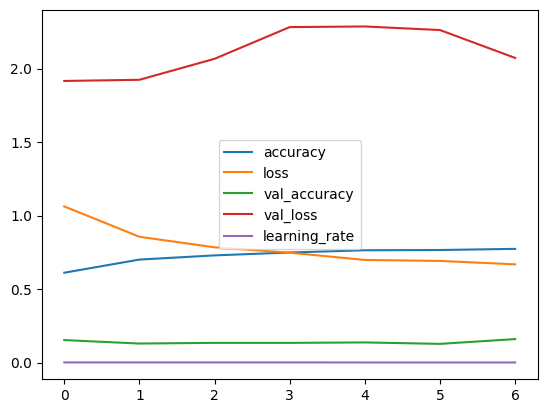

 1/21 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.1250 - loss: 2.0999

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.1749 - loss: 1.9321
loss: 1.9110, accuracy: 0.1770


In [13]:
# @title 미세조정 1단계 : 분류층 레이어만 학습
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# 특성추출층 freeze
for layer in model.layers[:-5]:
  layer.trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001), # 'adam' -> Adam() 실제 객체로 변환후 학습이 진행되고 있다?
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=6, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# 학습
history = model.fit(
    tr_seq,
    epochs=40,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb])

# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')